# Bass guitar simulation using siconos

## Jupyter notebooks reminder

A notebook is a sequence of "cells" that can be executed.


Each cell can handle either python code or markdown for comments.

* Edit a cell : Enter
* Execute a cell: Shift + Enter
* Run all cells : kernel menu (top of the page) --> Run all
* Delete cell : DD
* Add cell : Ctrl-mb
* Shortcuts reminder : Ctrl-m h
* List all magic commands : %lsmagic

More :  https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html#references

Warning : cells can be executed in any order but results and variables are persistent (until a call to %reset or kernel->restart)


## Debug/test mode only

Execute the cell below only during debug/profile phase

In [1]:
# Load profiler    
%load_ext line_profiler
# Reload automatically all python modules before each cell exec
%load_ext autoreload
%autoreload 2

## Load siconos and guitar packages

In [2]:
# standard python packages
import sys
import time
import os
# guitar package
from guitar import StringDS, Fret, Guitar
from model_tools import build_frets_from_file, save_simu_to_hdf5

# Guitar pre-defined setups
import parameters

# siconos package
import siconos.kernel as sk

# python packages for vectors/matrices operations
import numpy as np
import scipy.io
# python plots
import matplotlib.pyplot as plt
%matplotlib inline

## Create a 'guitar' model

Build dynamical systems, interactions, simulation ...
   

Parameters: 

* number_of_modes :  spatial discretisation
* max_coords : coordinates of the shifted point at t0
* fe : sampling freq
* final_time : ...
* frets_file : input file (matlab) to set frets positions on the neck
* filt_frets : true set interactions only on frets. If false, set contact at each dof on the neck.
* enable_frets_output : if true, save interactions data at each time step.


### Select case :

comment/uncomment lines below

In [3]:
# One string, one contact
# case = 'one_contact'
# 'standard' bass : one string, 20 frets
case = 'bass'
# Fretless bass
#case = 'fretless'

# Activate (or not) contacts
with_contacts = True

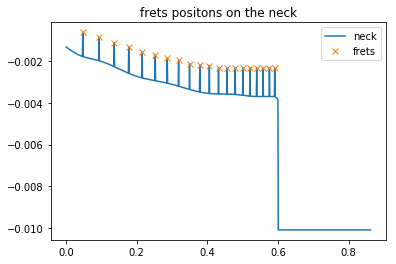

In [4]:
if case == 'bass':
        
    run_case = parameters.bass_guitar

elif case == 'fretless':
    
    run_case = parameters.fretless_bass_guitar

elif case == 'one_contact':

    run_case = parameters.one_contact

# set or overload parameters value
matlab_input = run_case['matlab_input']
number_of_modes = run_case['nb_modes']
max_coords = run_case['max_coords']
filt_frets = run_case['filt_frets']
G_string = {
    'length': run_case['length']
    # diameter = equivalent diameter (A5)
    #'diameter': 1.14e-3,
    #'density': 6.69e-3,
    #'B': 3.5e-5,
    #'tension': 191.6,
    }

output_name = run_case['output_name']

restit = 0.9

output_name += str(restit)

initial_time = 0.
final_time = 0.1
visu = True # plot frets/neck 

fs = 15680. #1003520
output_freq = 64


# -- The dynamical system --
string = StringDS(number_of_modes, geometry_and_material=G_string,
                  max_coords=max_coords,
                  matlab_input=matlab_input)

# -- Contacts/interactions --
current_path = './'
if with_contacts:
    frets_file = os.path.join(current_path, matlab_input) + '_h.mat'
    interactions = build_frets_from_file(string, restit, frets_file, filt_frets, visu)

    frets = list(interactions.keys())
    nb_frets = len(frets)
else:

    interactions = {None : string}
    frets = []
    nb_frets = len(frets)

In [5]:
nsds = sk.NonSmoothDynamicalSystem(initial_time, final_time)
nsds.insertDynamicalSystem(string)
nsds.link(frets[0],string )

In [6]:
moreau_bilbao = sk.MoreauJeanBilbaoOSI()
moreau_jean = sk.MoreauJeanOSI(0.5)


t = sk.TimeDiscretisation(initial_time, 1./fs)
osnspb = sk.LCP()
simulation = sk.TimeStepping(nsds, t, moreau_jean, osnspb)

In [ ]:
simulation.computeOneStep()

In [ ]:
guitar_model = Guitar(interactions, [initial_time, final_time],
                      fs, output_freq, interactions_output=2,
                         default_integrator='MoreauJean') # 2 to save y and lambda
# Save initial state
guitar_model.time[0] = initial_time
guitar_model.save_ds_state_modal(0, string)

buff = guitar_model.data_interactions
for i in range(nb_frets):
    buff[frets[i]][0][0] = frets[i].y(0) 
    buff[frets[i]][1][0] = frets[i].lambda_(1) 

# Get simulation object
simu = guitar_model.simulation
osns = guitar_model.osnspb
osi = guitar_model.default_integrator
print('Ready to start simulation for frequency {0}.'.format(fs))
print('Save output every {0} time steps.'.format(output_freq))
msg = 'Read data from files :\n'
msg += '- neck profile:' + frets_file
msg += '\n- eigenfrequencies: ' + matlab_input + '_frequs.mat\n'
msg += '- damping: ' + matlab_input + '_amortissements.mat\n'
print(msg)


res = np.sqrt(guitar_string.stiffness()) / (2. *np.pi)
sig = guitar_string.damping() * 0.5
res.shape
q0 = np.dot(guitar_string.s_mat,guitar_string.q0())
res.shape
x = np.linspace(0, guitar_string.length, n_modes+2)[1:-1]
frequencies[-1], res[-1]
damp2 = guitar_string.compute_damping(res)
u0 = guitar_string._compute_initial_state_std(max_coords=(7.8e-3, .64))
#plt.plot(x, u0)
#plt.xlim(0,3*guitar_string.space_step)
#plt.ylim(0,0.00004)
damp2[0:5], sig[0:5]
plt.plot(x, amort, x, sig,'--')
#plt.xlim(0,100)
#plt.ylim(0,1.3)
print(amort.shape)

## Run simulation

In [ ]:
def one_step(k, pos, start_time):
    simu.initialize()
    
    if k % 100000 == 0:
        print('step = ', k, '---- time = ',
              simu.nextTime(),
              '------- duration = ', time.clock() - start_time, '-------------')
    # - advanceToEvent() - TimeStepping.cpp
    simu.resetLambdas()
    # -- newtonSolve -- TimeStepping.cpp
    # --- simu.initializeNewtonLoop() --- TimeStepping.cpp
    # skip # tkp1 = simu.getTkp1()
    # skip #   guitar_model.default_integrator.computeInitialNewtonState()
    # skip #   guitar_model.default_integrator.computeResidu()
    #simu.updateInteractions()
    #simu.updateWorldFromDS()
    #if simu.indexSet(0).size()>0:
    guitar_model.default_integrator.updateOutput(simu.nextTime())
    guitar_model.default_integrator.updateInput(simu.nextTime())
    # skip # guitar_string.updatePlugins(tkp1)
    # skip # guitar_model.default_integrator.computeResidu()
    # --- --- end of initializeNewtonLoop
    # skip # simu.prepareNewtonIteration()
    simu.computeFreeState()
    # --- ComputeOneStepNSProblem --- Simulation.cpp
    #if simu.nonSmoothDynamicalSystem().topology().hasChanged():
    osns.setHasBeenUpdated(False)
    # ---- osnsob.compute() ---- LCP.cpp
    #cont = precompute(simu.nextTime())
    
    sindex = sk.size_graph(simu.indexSet(osns.indexSetLevel()))
    #if sindex > 0:
    #    print("I1 size/ iteration number", sindex, k)
    res = False
    if sindex != 0:    
        #up2date = osns.hasBeenUpdated()
        #if not up2date:
        osns.updateInteractionBlocks()
        osns.updateOperators()
        res = True
        osns.computeq(time)
    #osns.displayBlocks(simu.indexSet(1))
    # osns.computeq(simu.nextTime())
    info = 0
    if res:
        if osns.getSizeOutput() != 0:
            info = osns.numericsCompute()
            osns.postCompute()
    # ---- ---- end of compute
    # --- --- end of computeOneStepNSProblem
    #simu.computeOneStepNSProblem(sk.SICONOS_OSNSP_TS_VELOCITY)
    simu.DefaultCheckSolverOutput(info)
    # --- update --- Simulation.hpp
    simu.updateInput()
    simu.updateState()
    simu.updateOutput()
    # --- --- end of update
    simu.saveYandLambdaInOldVariables()
    # -- -- end of newtonSolve
    # - - end of advanceToEvent
    # -- save data every output_freq time step --
    if k % guitar_model.output_freq == 0:
        # current time
        guitar_model.time[pos] = simu.nextTime()
        # modal positions
        guitar_model.save_ds_state_modal(pos, string)
        
        # interactions
        if guitar_model.save_interactions:
            buff = guitar_model.data_interactions
            for i in range(nb_frets):
                buff[frets[i]][0][pos] = frets[i].y(0) 
                buff[frets[i]][1][pos] = frets[i].lambda_(1) 
                #buff[frets[i]][2][pos = frets[i].y(1) 

        pos += 1
    k += 1
    simu.nextStep()
    return k, pos

def run():
    k = 1
    pos = 1
    #while k < 500:
    #while simu.nextTime() < 1.:
    start_time = time.clock() 
    while simu.hasNextEvent():
        k, pos = one_step(k, pos, start_time)



In [ ]:
osi.iteration_matrix(string)

In [ ]:
one_step(1, 1, time.clock())

In [ ]:
%lprun -f  one_step run()

#  Post-treatment

## Save data to hdf file

In [ ]:
guitar_model.convert_modal_output(string)

In [ ]:
save_simu_to_hdf5(guitar_model, string, matlab_data=matlab_input, filename='./tmp.h5', filt_frets=filt_frets, restit=restit)

## Plot trajectories
Use plotTraj(dynamical_system, list of dof to be plotted)

If list of dof is not set, all dof will be plotted.

Result = dof as a function of time +  zoom specific ranges (as in the paper)

To save the resulting figure(s), add argument filename when calling plotTraj

Arg 'iplot' is used to change figure number. Set same iplot if you want to plot all curves on the same figure.
Default iplot=0.

In [ ]:
# Plot dof 10 and 50
guitar_model.plot_traj(guitar_string, dof=[ipos], iplot=0)
# Plot all dof
#guitar_model.plot_traj(guitar_string, iplot=1)
# Plot dof 55 and save result in displacements_55.pdf
#guitar_model.plot_traj(guitar_string, dof=[55], filename='displacements_55.pdf', iplot=2)

## Plot modes

Use guitar_model.plot_modes(guitar_string,plot_shape)

plot_shape = (x,y) where x,y is the resolution of the grid of plots.

Example: 
plot_modes(guitar_string, (4,2)) : splits time range in 8 and plots dof=f(x) for those 8 time instants on 8 figures


Set filename arg to save resulting figure in a file.

In [ ]:
# Plot 10 figures on two columns, for 10 time instants
guitar_model.plot_modes(guitar_string,plot_shape=[5,2], iplot=0)
# Same thing but save output in modes.pdf
#guitar_model.plot_modes(guitar_string,plot_shape=[5,3], filename='modes.pdf', iplot=1)
# plot modes for time[12] and time[5000] on one column
#guitar_model.plot_modes(guitar_string, times =[12, 1200], plot_shape=(2,1), filename='modes2.pdf', iplot=2)

## Create a movie mode=f(time)

In [ ]:
guitar_model.make_movie(guitar_string,'fretless.mp4')

<video controls src="fretless.mp4" />
#%%html
#<video width="320" height="240" controls>
#  <source src="./fretless.mp4" type="video/mp4">
#</video>

## Plot contactogram

    !! Works only if enable_interactions_output=True in model (guitar_model) constructor

In [ ]:
guitar_model.contactogram(guitar_string)

In [ ]:
v1 = np.arange(3)
v2 = np.arange(3,8)
vref = np.arange(8)
v3 = sk.BlockVector(v1, v2)
v4 = np.ones(vref.size)
print(v2)

In [ ]:
np.dot(v4, vref)

In [ ]:
v5 = sk.SiconosVector(4)

In [ ]:
1+1